## 0. MLP 모델 설계 순서

>1. 모듈 임포트  
2. 장비 확인  
3. 데이터 다운로드  
4. 데이터 확인  
5. MLP 설계  
6. Optimizer, Objective Function 설정    
7. 학습 데이터에 대한 모델 성능 확인하는 함수 정의  
8. 검증 데이터에 대한 모델의 성능을 확인하는 함수 정의  
9. 모델 학습 및 성능 확인  

## 1. 모듈 임포트

In [45]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

from torchsummary import summary

## 2. 장비 확인

In [36]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else :
    DEVICE = torch.device('cpu')
    
print('Using Pytorch version:', torch.__version__, 'Device : ', DEVICE)

Using Pytorch version: 1.9.0 Device :  cpu


In [37]:
BATCH_SIZE = 32 
EPOCHS = 10

## 3. CIFAR10 데이터 다운로드(Train/Test 분리)

- CIFAR_10 데이터 셋은 **컬러 이미지 데이터**이다. 데이터를 다운로드할 때 이미지 데이터에 대한 **기본적인 전처리**를 동시에 진행한다.  
- ToTensor() 메서드를 이용해 **텐서 형태로 데이터를 변경**하고, **픽셀을 0과 1 사이의 값으로 정규화**한다.
- 모델이 정보의 순서를 암기해 학습을 진행하는 것을 방지하고자 **shuffle = True**로 설정한다.


In [38]:
train_dataset = datasets.CIFAR10(root = '../data/CIFAR_10',
                                train = True,
                                download = True,
                                transform = transforms.ToTensor())

test_dataset = datasets.CIFAR10(root = '../data/CIFAR_10',
                                train = False,
                                transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = True)

Files already downloaded and verified


## 4. 데이터 확인

- 훈련용 데이터 50,000개, 테스트용 데이터 10,000개
- 훈련용 데이터의 미니배치 개수는 1563, 테스트용 데이터의 미니배치 개수는 313
- **하나의 미니배치(X_train)**에는 **32개의 이미지 데이터**가 존재
- **하나의 이미지 데이터**는 **가로 32개, 세로 32개의 픽셀**로 이뤄져있고 **채널은 3(RGB)** 

In [39]:
print("train_dataset : ", len(train_loader.dataset))
print("test_dataset : ", len(test_loader.dataset))

print("train_loader : ", len(train_loader)) # 미니배치 개수 = iteration 횟수
print("test_loader : ", len(test_loader)) # 미니배치 개수 = iteration 횟수

train_dataset :  50000
test_dataset :  10000
train_loader :  1563
test_loader :  313


In [40]:
for(X_train, y_train) in train_loader:
    # Mini-batch 1개 안의 데이터 확인
    print('X_train:', X_train.size(), 'type:',X_train.type())
    print('y_train:', y_train.size(), 'type:',y_train.type())
    break

X_train: torch.Size([32, 3, 32, 32]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


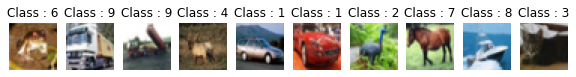

In [41]:
# 데이터 시각화
pltsize = 1
plt.figure(figsize = (10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i],(1,2,0)))
    plt.title('Class : ' + str(y_train[i].item()))

In [42]:
print('before np.transpose : ', X_train[0].size())
print('after np.transpose : ',np.transpose(X_train[i],(1,2,0)).size())

before np.transpose :  torch.Size([3, 32, 32])
after np.transpose :  torch.Size([32, 32, 3])


## 5. MLP 설계

- 첫 번째 Fully Connected Layer
    - input : 32 * 32 * 3 (가로 픽셀 수 * 세로 픽셀 수 * 채널 수)
    - output : 512개의 노드  
    
    
- 두 번째 Fully Connected Layer
    - input : 512개의 노드
    - output : 256개의 노드  
    
    
- 세 번째 Fully Connected Layer
    - input : 256개의 노드
    - output ; 10개의 노드. CIFAR-10 데이터 세트는 총 10가지 클래스로 구성.

In [43]:
class Net(nn.Module): 
    def __init__(self): 
        super(Net, self).__init__() 
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256, 10)
    
    # Forward Propagation
    def forward(self, x): 
        x = x.view(-1, 32 * 32 * 3) 
        x = self.fc1(x) 
        x = F.sigmoid(x) 
        x = self.fc2(x)
        x = F.sigmoid(x)
        x = self.fc3(x) 
        x = F.log_softmax(x, dim = 1)
        return x 

## 6. Optimizer, Objective Function 설정

- MLP 모델을 DEVICE에 할당
- 최적화 방식은 Adam
- 최적화에 사용될 손실함수는 CrossEntropyLoss

In [48]:
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

In [49]:
# print(model)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]       1,573,376
            Linear-2                  [-1, 256]         131,328
            Linear-3                   [-1, 10]           2,570
Total params: 1,707,274
Trainable params: 1,707,274
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.01
Params size (MB): 6.51
Estimated Total Size (MB): 6.53
----------------------------------------------------------------


## 7. 학습 데이터에 대한 모델 성능 확인하는 함수 정의

1. MLP 모델을 학습 상태로 지정
2. Mini-batch 단위로 저장된 데이터를 순서대로 이용하여 모델 학습
3. 이미지 데이터와 레이블 데이터를 기존에 정의한 장비에 할당
4. Optimizer 초기화
5. output 계산 
6. CrossEntropy를 통해 Loss 계산
7. Backpropagation을 통한 파라미터 업데이트

In [61]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    print("------------------- Training..... -------------------\n")
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        
        loss = criterion(output, label)
        loss.backward()
        optimizer.step() # 파라미터 업데이트
        
        if batch_idx % log_interval == 0 :
            print("Train Epoch: {} [{}/{}]\tTrain Loss: {:.6f}".format(Epoch,
                                                                       len(image) * batch_idx,
                                                                       len(train_loader.dataset),
                                                                       loss.item()))
    print("------------------------------------------------------\n")   

## 8. 검증 데이터에 대한 모델 성능을 확인하는 함수 정의

1. 모델을 평가 상태로 지정
2. Gradient의 흐름을 억제하여 파라미터 값이 업데이트되는 현상 방지
3. 이후 과정은 *7. 학습 데이터에 대한 모델 성능을 확인하는 함수 정의* 와 동일

In [62]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            
            output = model(image)
            test_loss += criterion(output, label)
            prediction = output.max(1, keepdim = True)[1] # 가장 큰 확률 값을 지니는 클래스의 인덱스만 추출
            correct += prediction.eq(label.view_as(prediction)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    
    return test_loss, test_accuracy

## 9. 모델 학습 및 성능 확인

In [63]:
for Epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print("[EPOCH: {}], \tTest Loss: {:.4f}, \tTest Accracy: {:.2f}%\n".format(Epoch,
                                                                            test_loss,
                                                                            test_accuracy))

------------------- Training..... -------------------

Train Epoch: 1 [0/50000]	Train Loss: 2.002258
Train Epoch: 1 [6400/50000]	Train Loss: 1.583277
Train Epoch: 1 [12800/50000]	Train Loss: 1.583984
Train Epoch: 1 [19200/50000]	Train Loss: 1.802283
Train Epoch: 1 [25600/50000]	Train Loss: 1.771399
Train Epoch: 1 [32000/50000]	Train Loss: 1.756756
Train Epoch: 1 [38400/50000]	Train Loss: 1.857253
Train Epoch: 1 [44800/50000]	Train Loss: 1.802579
------------------------------------------------------

[EPOCH: 1], 	Test Loss: 0.0551, 	Test Accracy: 36.78%

------------------- Training..... -------------------

Train Epoch: 2 [0/50000]	Train Loss: 2.035973
Train Epoch: 2 [6400/50000]	Train Loss: 1.565566
Train Epoch: 2 [12800/50000]	Train Loss: 1.539480
Train Epoch: 2 [19200/50000]	Train Loss: 1.746009
Train Epoch: 2 [25600/50000]	Train Loss: 1.717258
Train Epoch: 2 [32000/50000]	Train Loss: 1.723329
Train Epoch: 2 [38400/50000]	Train Loss: 1.883714
Train Epoch: 2 [44800/50000]	Train Loss